In [69]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image
import imagezmq
import imutils
import cv2
from ISR.models import RDN,RRDN
import random

from imutils import build_montages
from datetime import datetime


from tensorflow.keras.preprocessing import image

In [2]:
url = 'https://upload.wikimedia.org/wikipedia/commons/5/5e/Diana%2C_Princess_of_Wales_1997_%282%29.jpg'
#url = 'https://upload.wikimedia.org/wikipedia/commons/5/57/Mitsotakis_1992.jpg'
#url = 'https://upload.wikimedia.org/wikipedia/commons/1/14/Diego_Maradona_2012_2.jpg'

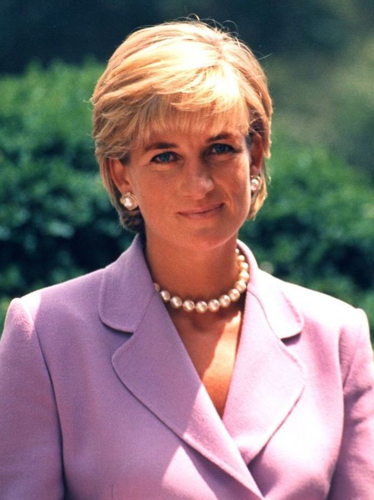

In [3]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [186]:
base_model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')

96116736/96112376 [==============================] - 9s 0us/step


In [187]:
# Maximize the activations of these layers
names = ['mixed1','mixed3','mixed7']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Calculate loss

The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

In [188]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

## Gradient ascent

Once you have calculated the loss for the chosen layers, all that is left is to calculate the gradients with respect to the image, and add them to the original image. 

Adding the gradients to the image enhances the patterns seen by the network. At each step, you will have created an image that increasingly excites the activations of certain layers in the network.

The method that does this, below, is wrapped in a `tf.function` for performance. It uses an `input_signature` to ensure that the function is not retraced for different image sizes or `steps`/`step_size` values. See the [Concrete functions guide](../../guide/concrete_function.ipynb) for details.

In [189]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [190]:
deepdream = DeepDream(dream_model)

## Optional: Scaling up with tiles

One thing to consider is that as the image increases in size, so will the time and memory necessary to perform the gradient calculation. The above octave implementation will not work on very large images, or many octaves.

To avoid this issue you can split the image into tiles and compute the gradient for each tile.

Applying random shifts to the image before each tiled computation prevents tile seams from appearing.

Start by implementing the random shift:

In [191]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0],shift[1] 
  img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled

In [192]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=512):
    shift_down, shift_right, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients

In [193]:
get_tiled_gradients = TiledGradients(dream_model)

In [200]:
def run_deep_dream_with_octaves(img, steps_per_octave=8, step_size=0.5, 
                                octaves=range(-3,2), octave_scale=1.6):
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)
    
  result = deprocess(img)
  return result

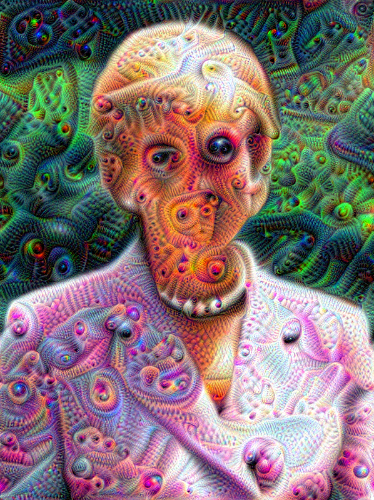

In [201]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.05)

display.clear_output(wait=True)
base_shape = tf.shape(original_img)[:-1]
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

In [205]:
def startServer(montageW,montageH, isLocal):
    
    # initialize the ImageHub object or VideoCapture object for local webcam
    if(isLocal):
        video = cv2.VideoCapture(0)
    else:
        imageHub = imagezmq.ImageHub()
    
    frameDict = {}
    
    #load rdn or rrdn model for image enhancing(optional: line is commented out)
    rdn = RDN(weights='psnr-large')#RRDN(weights='gans')

    # initialize the dictionary which will contain  information regarding
    # when a device was last active, then store the last time the check
    # was made was now
    lastActive = {}
    lastActiveCheck = datetime.now()

    # stores the estimated number of Pis, active checking period, and
    # calculates the duration seconds to wait before making a check to
    # see if a device was active
    ESTIMATED_NUM_PIS = 4
    ACTIVE_CHECK_PERIOD = 20
    ACTIVE_CHECK_SECONDS = ESTIMATED_NUM_PIS * ACTIVE_CHECK_PERIOD

    # assign montage width and height so we can view all incoming frames
    # in a single "dashboard"
    mW = montageW
    mH = montageH
    print("[INFO] detecting: {}...")

    # start looping over all the frames
    while True:
        # receive RPi name and frame from the RPi and acknowledge
        # the receipt
        if(isLocal):
            rpiName = "elmo"
            _, frame = video.read()
        else:
            (rpiName, frame) = imageHub.recv_image()
            imageHub.send_reply(b'OK')

        # if a device is not in the last active dictionary then it means
        # that its a newly connected device
        if rpiName not in lastActive.keys():
            print("[INFO] receiving data from {}...".format(rpiName))

        # record the last active time for the device from which we just
        # received a frame
        lastActive[rpiName] = datetime.now()

        # resize the frame to have a maximum width of 400 pixels, then
        # grab the frame dimensions and construct a blob
        #frame = imutils.resize(frame, width=400)
        newframe = run_deep_dream_with_octaves(img=frame,steps_per_octave=random.randint(8,10) , step_size=0.05)
        base_shape = tf.shape(frame)[:-1]
        newframe = tf.image.resize(newframe, base_shape)
        newframe = tf.image.convert_image_dtype(newframe/255.0, dtype=tf.uint8)
        
        newframe = newframe.numpy()
        if(isLocal):
            scale_percent = 183 # percent of original size
            width = int(newframe.shape[1] * scale_percent / 100)
            height = int(newframe.shape[0] * scale_percent / 100)
            dim = (width, height)
            resized = cv2.resize(newframe, dim, interpolation = cv2.INTER_AREA)
            #resized_enh = rdn.predict(montage)
            cv2.imshow("webcam stream ({})".format(rpiName),
                resized)
        else:
            #newframe = tf.image.convert_image_dtype(newframe/255.0, dtype=tf.uint8)
            (h, w) = newframe.shape[:2]
            #blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)),
                #0.007843, (300, 300), 127.5)

            # update the new frame in the frame dictionary
            frameDict[rpiName] = newframe

            # build a montage using images in the frame dictionary
            montages = build_montages(frameDict.values(), (w, h), (mW, mH))
    
            # display the montage(s) on the screen
            for (i, montage) in enumerate(montages):
                scale_percent = 200 # percent of original size
                width = int(montage.shape[1] * scale_percent / 100)
                height = int(montage.shape[0] * scale_percent / 100)
                dim = (width, height)
                resized = cv2.resize(montage, dim, interpolation = cv2.INTER_AREA)
                #resized_enh = rdn.predict(montage)
                cv2.imshow("webcam stream ({})".format(i),
                    resized)
             # if current time *minus* last time when the active device check
             # was made is greater than the threshold set then do a check
            if (datetime.now() - lastActiveCheck).seconds > ACTIVE_CHECK_SECONDS:
                # loop over all previously active devices
                for (rpiName, ts) in list(lastActive.items()):
                    # remove the RPi from the last active and frame
                    # dictionaries if the device hasn't been active recently
                    if (datetime.now() - ts).seconds > ACTIVE_CHECK_SECONDS:
                        print("[INFO] lost connection to {}".format(rpiName))
                        lastActive.pop(rpiName)
                        frameDict.pop(rpiName)

                # set the last active check time as current time
                lastActiveCheck = datetime.now()

        # detect any kepresses
        key = cv2.waitKey(1) & 0xFF

        
        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

    # do a bit of cleanup
    cv2.destroyAllWindows()

In [206]:
startServer(1, 1, True)

[INFO] detecting: {}...
[INFO] receiving data from elmo...
